<a href="https://colab.research.google.com/github/KareemEzzaldin/Nature-Inspired-Computation-Project/blob/main/NIC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

## Imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configure GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

print("Hyperparameter Optimization with 4 Metaheuristics")

# Load and preprocess the dataset
print("Loading Blood Cells Dataset")
try:
    import kagglehub
    path = kagglehub.dataset_download("paultimothymooney/blood-cells")

    # Find data directory
    possible_paths = [
        os.path.join(path, "dataset2-master", "images"),
        os.path.join(path, "dataset2-master", "dataset-master", "images"),
        os.path.join(path, "images"),
        path
    ]

    data_dir = None
    for p in possible_paths:
        if os.path.exists(p) and os.path.isdir(p):
            subdirs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
            if len(subdirs) > 0:
                data_dir = p
                print(f" Found data directory: {data_dir}")
                print(f" Classes found: {subdirs}")
                break

    if data_dir is None:
        raise FileNotFoundError("Could not find image directory")

except Exception as e:
    print(f" Error: {e}")
    exit(1)

# Create data generators
def create_data_generators(batch_size=32):
    "Create train and validation data generators"
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_data = train_datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        subset='training',
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_data = val_datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    return train_data, val_data

# Initial load to get dataset info
train_data, val_data = create_data_generators()
num_classes = len(train_data.class_indices)
input_shape = (128, 128, 3)

print(f" Training samples: {train_data.samples}")
print(f" Validation samples: {val_data.samples}")
print(f" Number of classes: {num_classes}")
print(f" Input shape: {input_shape}")

Hyperparameter Optimization with 4 Metaheuristics
Loading Blood Cells Dataset
 Found data directory: /kaggle/input/
 Classes found: ['dataset-master', 'dataset2-master']
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
 Training samples: 10305
 Validation samples: 2576
 Number of classes: 2
 Input shape: (128, 128, 3)


## CNN Model

In [ ]:
# Build CNN Model
def build_flexible_cnn(params, num_classes, input_shape):
    """
    Parameters to optimize:
    - learning_rate: [1e-5, 1e-2]
    - dropout_rate: [0.1, 0.6]
    - batch_size: [16, 32, 64, 128]
    - n_conv_layers: [2, 3, 4, 5]
    - base_filters: [16, 32, 64]
    """
    # Extract and validate parameters
    lr = np.clip(params[0], 1e-5, 1e-2)
    dropout = np.clip(params[1], 0.1, 0.6)
    batch_size = int(np.clip(params[2], 16, 128))
    n_conv_layers = int(np.clip(params[3], 2, 5))
    base_filters = int(np.clip(params[4], 16, 64))

    # Build model
    model = models.Sequential()

    # First conv layer
    model.add(layers.Conv2D(
        base_filters, (3, 3),
        activation='relu',
        input_shape=input_shape,
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Additional conv layers
    for i in range(1, n_conv_layers):
        filters = base_filters * (2 ** i)
        model.add(layers.Conv2D(filters, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    # Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout * 0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, batch_size

In [ ]:
#  Evaluation Function
def evaluate_params(params, epochs=4, verbose=0):

    try:
        # Build model
        model, batch_size = build_flexible_cnn(params, num_classes, input_shape)

        # Create data generators with specific batch size
        train_gen, val_gen = create_data_generators(batch_size=batch_size)

        # Train model
        history = model.fit(
            train_gen,
            epochs=epochs,
            verbose=verbose,
            validation_data=val_gen,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=2,
                    restore_best_weights=True
                )
            ]
        )

        # Evaluate
        _, accuracy = model.evaluate(val_gen, verbose=0)

        # Cleanup
        del model
        tf.keras.backend.clear_session()

        return accuracy

    except Exception as e:
        print(f" Error evaluating params: {e}")
        return 0.0

In [ ]:
# Basline Model
print(" Training Baseline Model")
baseline_params = [0.001, 0.3, 32, 3, 32]  # [lr, dropout, batch_size, n_conv, filters]
print(f"Baseline parameters: LR={baseline_params[0]}, Dropout={baseline_params[1]}, "
      f"BatchSize={int(baseline_params[2])}, ConvLayers={int(baseline_params[3])}, "
      f"Filters={int(baseline_params[4])}")

baseline_start = time.time()
baseline_acc = evaluate_params(baseline_params, epochs=10, verbose=1)
baseline_time = time.time() - baseline_start

print(f" Baseline Accuracy: {baseline_acc:.4f}")
print(f" Training Time: {baseline_time:.2f}s")

 Training Baseline Model
Baseline parameters: LR=0.001, Dropout=0.3, BatchSize=32, ConvLayers=3, Filters=32
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.9827 - loss: 0.1555 - val_accuracy: 0.9728 - val_loss: 0.0898
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 53s 165ms/step - accuracy: 0.9915 - loss: 0.0245 - val_accuracy: 0.9965 - val_loss: 0.0097
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 166ms/step - accuracy: 0.9923 - loss: 0.0180 - val_accuracy: 0.9763 - val_loss: 0.0467
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.9949 - loss: 0.0129 - val_accuracy: 0.9950 - val_loss: 0.0118
 Baseline Accuracy: 0.9965
 Training Time: 228.31s


## Define parameters

In [ ]:
# Metaheuristic Algorithms

# Define parameters
PARAM_BOUNDS = [
    (1e-5, 1e-2),   # learning_rate
    (0.1, 0.6),     # dropout_rate
    (16, 128),      # batch_size
    (2, 5),         # n_conv_layers
    (16, 64)        # base_filters
]

PARAM_NAMES = ['Learning Rate', 'Dropout', 'Batch Size', 'Conv Layers', 'Base Filters']
DISCRETE_PARAMS = [False, False, True, True, True]

## PSO

In [ ]:
# Particle Swarm Optimization (PSO)
class ParticleSwarmOptimization:
    "PSO for hyperparameter optimization"

    def __init__(self, n_particles=4, n_iterations=1, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def optimize(self, fitness_func, bounds, discrete_params):
        "Run PSO optimization"
        n_dims = len(bounds)
        lower = np.array([b[0] for b in bounds])
        upper = np.array([b[1] for b in bounds])

        # Initialize
        particles = np.random.uniform(lower, upper, (self.n_particles, n_dims))
        velocities = np.random.randn(self.n_particles, n_dims) * 0.1

        pbest = particles.copy()
        pbest_scores = np.array([fitness_func(p) for p in pbest])

        gbest_idx = np.argmax(pbest_scores)
        gbest = pbest[gbest_idx].copy()
        gbest_score = pbest_scores[gbest_idx]

        history = []

        print(f"PSO: Initial best = {gbest_score:.4f}")

        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.rand(n_dims), np.random.rand(n_dims)

                velocities[i] = (
                    self.w * velocities[i] +
                    self.c1 * r1 * (pbest[i] - particles[i]) +
                    self.c2 * r2 * (gbest - particles[i])
                )

                particles[i] += velocities[i]
                particles[i] = np.clip(particles[i], lower, upper)

                # Handle discrete params
                for j, is_discrete in enumerate(discrete_params):
                    if is_discrete:
                        particles[i][j] = round(particles[i][j])

                score = fitness_func(particles[i])

                if score > pbest_scores[i]:
                    pbest[i] = particles[i].copy()
                    pbest_scores[i] = score

                    if score > gbest_score:
                        gbest = particles[i].copy()
                        gbest_score = score

            history.append({
                'iteration': iteration + 1,
                'best_score': gbest_score,
                'mean_score': np.mean(pbest_scores)
            })

            print(f"  Iter {iteration+1}/{self.n_iterations}: Best={gbest_score:.4f}, Mean={np.mean(pbest_scores):.4f}")

        return gbest, gbest_score, history

## SA

In [ ]:
# Simulated Annealing(SA)
class SimulatedAnnealing:
    "Simulated Annealing for hyperparameter optimization"

    def __init__(self, n_iterations=1, initial_temp=1.0, cooling_rate=0.95):
        self.n_iterations = n_iterations
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate

    def optimize(self, fitness_func, bounds, discrete_params):
        "Run SA optimization"
        n_dims = len(bounds)
        lower = np.array([b[0] for b in bounds])
        upper = np.array([b[1] for b in bounds])

        # Initialize random solution
        current = np.random.uniform(lower, upper, n_dims)
        for i, is_discrete in enumerate(discrete_params):
            if is_discrete:
                current[i] = round(current[i])

        current_score = fitness_func(current)
        best = current.copy()
        best_score = current_score

        temperature = self.initial_temp
        history = []

        print(f"SA: Initial score = {current_score:.4f}")

        for iteration in range(self.n_iterations):
            # Generate neighbor
            neighbor = current + np.random.randn(n_dims) * 0.1 * (upper - lower)
            neighbor = np.clip(neighbor, lower, upper)

            for i, is_discrete in enumerate(discrete_params):
                if is_discrete:
                    neighbor[i] = round(neighbor[i])

            neighbor_score = fitness_func(neighbor)

            # Acceptance probability
            delta = neighbor_score - current_score

            if delta > 0 or np.random.rand() < np.exp(delta / temperature):
                current = neighbor.copy()
                current_score = neighbor_score

                if current_score > best_score:
                    best = current.copy()
                    best_score = current_score

            # Cool down
            temperature *= self.cooling_rate

            history.append({
                'iteration': iteration + 1,
                'best_score': best_score,
                'current_score': current_score,
                'temperature': temperature
            })

            if (iteration + 1) % 10 == 0:
                print(f"  Iter {iteration+1}/{self.n_iterations}: Best={best_score:.4f}, "
                      f"Current={current_score:.4f}, Temp={temperature:.4f}")

        return best, best_score, history

## TS

In [ ]:
# Tabu Search (TS)
class TabuSearch:
    "Tabu Search for hyperparameter optimization"

    def __init__(self, n_iterations=1, tabu_tenure=10, n_neighbors=8):
        self.n_iterations = n_iterations
        self.tabu_tenure = tabu_tenure
        self.n_neighbors = n_neighbors

    def optimize(self, fitness_func, bounds, discrete_params):
        "Run Tabu Search optimization"
        n_dims = len(bounds)
        lower = np.array([b[0] for b in bounds])
        upper = np.array([b[1] for b in bounds])

        # Initialize
        current = np.random.uniform(lower, upper, n_dims)
        for i, is_discrete in enumerate(discrete_params):
            if is_discrete:
                current[i] = round(current[i])

        current_score = fitness_func(current)
        best = current.copy()
        best_score = current_score

        tabu_list = []
        history = []

        print(f"TS: Initial score = {current_score:.4f}")

        for iteration in range(self.n_iterations):
            # Generate neighbors
            neighbors = []
            for _ in range(self.n_neighbors):
                neighbor = current + np.random.randn(n_dims) * 0.15 * (upper - lower)
                neighbor = np.clip(neighbor, lower, upper)

                for i, is_discrete in enumerate(discrete_params):
                    if is_discrete:
                        neighbor[i] = round(neighbor[i])

                neighbors.append(neighbor)

            # Evaluate neighbors (excluding tabu)
            best_neighbor = None
            best_neighbor_score = -np.inf

            for neighbor in neighbors:
                # Check if in tabu list
                is_tabu = any(np.allclose(neighbor, tabu, atol=0.01) for tabu in tabu_list)

                if not is_tabu:
                    score = fitness_func(neighbor)

                    if score > best_neighbor_score:
                        best_neighbor = neighbor
                        best_neighbor_score = score

            # Move to best neighbor
            if best_neighbor is not None:
                current = best_neighbor.copy()
                current_score = best_neighbor_score

                # Update tabu list
                tabu_list.append(current.copy())
                if len(tabu_list) > self.tabu_tenure:
                    tabu_list.pop(0)

                # Update global best
                if current_score > best_score:
                    best = current.copy()
                    best_score = current_score

            history.append({
                'iteration': iteration + 1,
                'best_score': best_score,
                'current_score': current_score
            })

            if (iteration + 1) % 10 == 0:
                print(f"  Iter {iteration+1}/{self.n_iterations}: Best={best_score:.4f}, "
                      f"Current={current_score:.4f}")

        return best, best_score, history

## GA

In [ ]:
# Genetic Algorithm (GA)
class GeneticAlgorithm:
    "Genetic Algorithm for hyperparameter optimization"

    def __init__(self, population_size=10, n_generations=1,
                 mutation_rate=0.15, crossover_rate=0.8):
        self.population_size = population_size
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

    def optimize(self, fitness_func, bounds, discrete_params):
        "Run GA optimization"
        n_dims = len(bounds)
        lower = np.array([b[0] for b in bounds])
        upper = np.array([b[1] for b in bounds])

        # Initialize population
        population = []
        for _ in range(self.population_size):
            individual = np.random.uniform(lower, upper, n_dims)
            for i, is_discrete in enumerate(discrete_params):
                if is_discrete:
                    individual[i] = round(individual[i])
            population.append(individual)

        best = None
        best_score = -np.inf
        history = []

        print(f"GA: Initializing population of {self.population_size}")

        for generation in range(self.n_generations):
            # Evaluate fitness
            fitness = np.array([fitness_func(ind) for ind in population])

            # Update best
            if fitness.max() > best_score:
                best_score = fitness.max()
                best = population[fitness.argmax()].copy()

            history.append({
                'generation': generation + 1,
                'best_score': best_score,
                'mean_score': fitness.mean()
            })

            print(f"  Gen {generation+1}/{self.n_generations}: Best={best_score:.4f}, Mean={fitness.mean():.4f}")

            # Selection (tournament)
            new_population = []
            new_population.append(best.copy())  # Elitism

            while len(new_population) < self.population_size:
                # Select parents
                idx1, idx2 = np.random.choice(len(population), 2, replace=False)
                parent1 = population[idx1] if fitness[idx1] > fitness[idx2] else population[idx2]

                idx1, idx2 = np.random.choice(len(population), 2, replace=False)
                parent2 = population[idx1] if fitness[idx1] > fitness[idx2] else population[idx2]

                # Crossover
                if np.random.rand() < self.crossover_rate:
                    point = np.random.randint(1, n_dims)
                    child = np.concatenate([parent1[:point], parent2[point:]])
                else:
                    child = parent1.copy()

                # Mutation
                for i in range(n_dims):
                    if np.random.rand() < self.mutation_rate:
                        if discrete_params[i]:
                            child[i] = np.random.randint(bounds[i][0], bounds[i][1] + 1)
                        else:
                            child[i] += np.random.randn() * 0.1 * (bounds[i][1] - bounds[i][0])
                            child[i] = np.clip(child[i], bounds[i][0], bounds[i][1])

                new_population.append(child)

            population = new_population[:self.population_size]

        return best, best_score, history

## WOA

In [ ]:
class WOA:
    def __init__(self, n=8, iters=1, b=1.0):
        self.n, self.iters, self.b = n, iters, b
    def optimize(self, f, bounds, disc):
        d, lo, hi = len(bounds), np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
        X = lo+(hi-lo)*np.random.rand(self.n,d)
        for i in range(self.n):
            for j,dd in enumerate(disc):
                if dd: X[i][j]=round(X[i][j])
        best, bs = X[0].copy(), f(X[0])
        for i in range(self.n):
            s=f(X[i])
            if s>bs: best,bs=X[i].copy(),s
        hist = []
        for t in range(self.iters):
            a = 2-2*t/max(1,self.iters-1)
            for i in range(self.n):
                p,l = np.random.rand(), np.random.uniform(-1,1)
                if p<0.5:
                    X[i] = best-(2*a*np.random.rand(d)-a)*np.abs(2*np.random.rand(d)*best-X[i])
                else:
                    X[i] = np.abs(best-X[i])*np.exp(self.b*l)*np.cos(2*np.pi*l)+best
                X[i] = np.clip(X[i],lo,hi)
                for j,dd in enumerate(disc):
                    if dd: X[i][j]=round(X[i][j])
                s=f(X[i])
                if s>bs: best,bs=X[i].copy(),s
            hist.append({'iteration':t+1,'best_score':bs})
        return best,bs,hist

## BAT

In [ ]:
class BAT:
    def __init__(self, n=6, iters=1, fmin=0, fmax=2, loud=0.9, pulse=0.5):
        self.n,self.iters,self.fmin,self.fmax,self.loud,self.pulse=n,iters,fmin,fmax,loud,pulse
    def optimize(self, f, bounds, disc):
        d, lo, hi = len(bounds), np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
        X, V, freq = np.random.uniform(lo,hi,(self.n,d)), np.zeros((self.n,d)), np.zeros(self.n)
        for i in range(self.n):
            for j,dd in enumerate(disc):
                if dd: X[i][j]=round(X[i][j])
        scores = np.array([f(x) for x in X])
        best, bs = X[scores.argmax()].copy(), scores.max()
        hist = []
        for t in range(self.iters):
            for i in range(self.n):
                freq[i]=self.fmin+(self.fmax-self.fmin)*np.random.rand()
                V[i]+=(X[i]-best)*freq[i]
                cand=np.clip(X[i]+V[i] if np.random.rand()<=self.pulse else best+0.001*np.random.randn(d)*(hi-lo),lo,hi)
                for j,dd in enumerate(disc):
                    if dd: cand[j]=round(cand[j])
                s=f(cand)
                if s>scores[i] and np.random.rand()<self.loud:
                    X[i],scores[i]=cand.copy(),s
                    if s>bs: best,bs=cand.copy(),s
            hist.append({'iteration':t+1,'best_score':bs})
        return best,bs,hist

## CS

In [ ]:
class CuckooSearch:
    def __init__(self, n=8, iters=1, pa=0.25, step_scale=0.1):
        self.n, self.iters, self.pa, self.step = n, iters, pa, step_scale

    def optimize(self, f, bounds, disc):
        d = len(bounds)
        lo = np.array([b[0] for b in bounds])
        hi = np.array([b[1] for b in bounds])

        X = np.random.uniform(lo, hi, (self.n, d))
        for i in range(self.n):
            for j, dd in enumerate(disc):
                if dd:
                    X[i][j] = round(X[i][j])

        fit = np.array([f(x) for x in X])
        best, bs = X[fit.argmax()].copy(), fit.max()
        hist = []

        for t in range(self.iters):
            for i in range(self.n):
                cand = np.clip(X[i] + self.step * np.random.randn(d) * (hi - lo), lo, hi)
                for j, dd in enumerate(disc):
                    if dd:
                        cand[j] = round(cand[j])

                s = f(cand)
                j_rand = np.random.randint(0, self.n)
                if s > fit[j_rand]:
                    X[j_rand], fit[j_rand] = cand.copy(), s
                    if s > bs:
                        best, bs = cand.copy(), s

            for i in range(self.n):
                if np.random.rand() < self.pa:
                    X[i] = np.random.uniform(lo, hi, d)
                    for j, dd in enumerate(disc):
                        if dd:
                            X[i][j] = round(X[i][j])
                    fit[i] = f(X[i])
                    if fit[i] > bs:
                        best, bs = X[i].copy(), fit[i]

            hist.append({'iteration': t + 1, 'best_score': bs})

        return best, bs, hist

## SA OPtimize Pso

In [ ]:
sa_optimization_results = {}

def fitness_sa_pso(opt_params):
    # Clip parameters to valid ranges
    w = np.clip(opt_params[0], 0.2, 0.9)
    c1 = np.clip(opt_params[1], 0.5, 2.5)
    c2 = np.clip(opt_params[2], 0.5, 2.5)

    # Create PSO with these parameters
    pso_local = ParticleSwarmOptimization(
        n_particles=2,
        n_iterations=1,
        w=w,
        c1=c1,
        c2=c2
    )

    # Run PSO on CNN hyperparameters
    _, best_score, _ = pso_local.optimize(
        fitness_func=lambda p: evaluate_params(p, epochs=1, verbose=0),
        bounds=PARAM_BOUNDS,
        discrete_params=DISCRETE_PARAMS
    )

    return float(best_score)

# Define PSO parameter bounds for SA to search
pso_param_bounds = [
    (0.2, 0.9),   # w (inertia weight)
    (0.5, 2.5),   # c1 (cognitive parameter)
    (0.5, 2.5)    # c2 (social parameter)
]
pso_discrete = [False, False, False]

# Run SA to optimize PSO parameters
print(" Running SA optimization")
sa_for_pso = SimulatedAnnealing(
    n_iterations=1,
    initial_temp=1.0,
    cooling_rate=0.95
)

sa_pso_start = time.time()
best_pso_params, best_pso_score, sa_pso_history = sa_for_pso.optimize(
    fitness_func=fitness_sa_pso,
    bounds=pso_param_bounds,
    discrete_params=pso_discrete
)
sa_pso_time = time.time() - sa_pso_start

# Extract optimized PSO parameters
pso_w = float(best_pso_params[0])
pso_c1 = float(best_pso_params[1])
pso_c2 = float(best_pso_params[2])

print(f"Best PSO Parameters:")
print(f" w (inertia)    = {pso_w:.3f}")
print(f" c1 (cognitive) = {pso_c1:.3f}")
print(f" c2 (social)    = {pso_c2:.3f}")
print(f"Best Score: {best_pso_score:.4f}")
print(f"Time: {sa_pso_time:.2f}s")

# Store results
sa_optimization_results['SA->PSO'] = {
    'params': best_pso_params,
    'score': best_pso_score,
    'time': sa_pso_time,
    'history': sa_pso_history,
    'param_names': ['w', 'c1', 'c2']
}

 Running SA optimization
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
PSO: Initial best = 0.9717
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
  Iter 1/1: Best=0.9717, Mean=0.9717
SA: Initial score = 0.9717
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
PSO: Initial best = 0.9717
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
  Iter 1/1: Best=0.9717, Mean=0.9717
Best PSO Parameters:
 w (inertia)    = 0.809
 c1 (cognitive) = 1.478
 c2 (social)    = 2.221
Best Score: 0.9717
Time: 546.32s


## SA OPtimize TS

In [ ]:
# SA OPTIMIZES TS PARAMETERS
def fitness_sa_ts(opt_params):
    # Clip and cast to integers
    tabu_tenure = int(np.clip(round(opt_params[0]), 4, 12))
    n_neighbors = int(np.clip(round(opt_params[1]), 3, 6))

    # Create TS with these parameters
    ts_local = TabuSearch(
        n_iterations=1,
        tabu_tenure=tabu_tenure,
        n_neighbors=n_neighbors
    )

    # Run TS on CNN hyperparameters
    _, best_score, _ = ts_local.optimize(
        fitness_func=lambda p: evaluate_params(p, epochs=1, verbose=0),
        bounds=PARAM_BOUNDS,
        discrete_params=DISCRETE_PARAMS
    )

    return float(best_score)

# Define TS parameter bounds for SA to search
ts_param_bounds = [
    (4, 12),   # tabu_tenure
    (3, 6)     # n_neighbors
]
ts_discrete = [True, True]  # Both discrete

# Run SA to optimize TS parameters
print("Running SA optimization")
sa_for_ts = SimulatedAnnealing(
    n_iterations=1,
    initial_temp=1.0,
    cooling_rate=0.95
)

sa_ts_start = time.time()
best_ts_params, best_ts_score, sa_ts_history = sa_for_ts.optimize(
    fitness_func=fitness_sa_ts,
    bounds=ts_param_bounds,
    discrete_params=ts_discrete
)
sa_ts_time = time.time() - sa_ts_start

# Extract optimized TS parameters
ts_tenure = int(best_ts_params[0])
ts_neighbors = int(best_ts_params[1])

print(f"Best TS Parameters:")
print(f"tabu_tenure  = {ts_tenure}")
print(f"n_neighbors  = {ts_neighbors}")
print(f"Best Score: {best_ts_score:.4f}")
print(f"Time: {sa_ts_time:.2f}s")

# Store results
sa_optimization_results['SA->TS'] = {
    'params': best_ts_params,
    'score': best_ts_score,
    'time': sa_ts_time,
    'history': sa_ts_history,
    'param_names': ['tabu_tenure', 'n_neighbors']
}

print(f"SA->PSO Results:")
print(f"Optimized w={pso_w:.3f}, c1={pso_c1:.3f}, c2={pso_c2:.3f}")
print(f"Best Score: {best_pso_score:.4f}")
print(f"Time: {sa_pso_time:.2f}s")

print(f"Optimized tenure={ts_tenure}, neighbors={ts_neighbors}")
print(f"Best Score: {best_ts_score:.4f}")
print(f"Time: {sa_ts_time:.2f}s")

print(f"Total SA Optimization Time: {sa_pso_time + sa_ts_time:.2f}s")
print(f"PSO(n_particles=4, n_iterations=4, w={pso_w:.3f}, c1={pso_c1:.3f}, c2={pso_c2:.3f})")

print(f"TabuSearch(n_iterations=4, tabu_tenure={ts_tenure}, n_neighbors={ts_neighbors})")

Running SA optimization
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
TS: Initial score = 0.9957
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
SA: Initial score = 0.9957
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
TS: Initial score = 0.0283
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Fo

In [ ]:
# Run the Optimizations
print(" Running Metaheuristic Optimizations")
results = {}

# PSO
print("Run PSO")
pso_start = time.time()
pso = ParticleSwarmOptimization(n_particles=2, n_iterations=1)
pso_params, pso_score, pso_history = pso.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
pso_time = time.time() - pso_start

results['PSO'] = {
    'params': pso_params,
    'score': pso_score,
    'time': pso_time,
    'history': pso_history
}

print(f" PSO Complete: Score={pso_score:.4f}, Time={pso_time:.2f}s")

# SA
print("Run SA")
sa_start = time.time()
sa = SimulatedAnnealing(n_iterations=1, initial_temp=1.0, cooling_rate=0.95)
sa_params, sa_score, sa_history = sa.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
sa_time = time.time() - sa_start

results['SA'] = {
    'params': sa_params,
    'score': sa_score,
    'time': sa_time,
    'history': sa_history
}

print(f" SA Complete: Score={sa_score:.4f}, Time={sa_time:.2f}s")

# Tabu Search
print("Run TS")
ts_start = time.time()
ts = TabuSearch(n_iterations=1, tabu_tenure=8, n_neighbors=6)
ts_params, ts_score, ts_history = ts.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
ts_time = time.time() - ts_start

results['TS'] = {
    'params': ts_params,
    'score': ts_score,
    'time': ts_time,
    'history': ts_history
}

print(f" TS Complete: Score={ts_score:.4f}, Time={ts_time:.2f}s")

# GA
print("Run GA")
ga_start = time.time()
ga = GeneticAlgorithm(population_size=5, n_generations=1)
ga_params, ga_score, ga_history = ga.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
ga_time = time.time() - ga_start

results['GA'] = {
    'params': ga_params,
    'score': ga_score,
    'time': ga_time,
    'history': ga_history
}

print(f" GA Complete: Score={ga_score:.4f}, Time={ga_time:.2f}s")

# WOA
print("Run WOA")
woa_start = time.time()
woa = WOA(n=4, iters=1, b=1.0)
woa_params, woa_score, woa_history = woa.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
woa_time = time.time() - woa_start

results['WOA'] = {
    'params': woa_params,
    'score': woa_score,
    'time': woa_time,
    'history': woa_history
}

print(f" WOA Complete: Score={woa_score:.4f}, Time={woa_time:.2f}s")

# BAT
print("Run BA")
ba_start = time.time()
ba = BAT(n=4, iters=1, fmin=0, fmax=2, loud=0.9, pulse=0.5)
ba_params, ba_score, ba_history = ba.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
ba_time = time.time() - ba_start

results['BA'] = {
    'params': ba_params,
    'score': ba_score,
    'time': ba_time,
    'history': ba_history
}
print(f"BA Complete: Score={ba_score:.4f}, Time={ba_time:.2f}s")

# CS
print("Run CS")
cs_start = time.time()
cs = CuckooSearch(n=6, iters=1, pa=0.25, step_scale=0.10)
cs_params, cs_score, cs_history = cs.optimize(evaluate_params, PARAM_BOUNDS, DISCRETE_PARAMS)
cs_time = time.time() - cs_start

results["CS"] = {
    "params": cs_params,
    "score": cs_score,
    "time": cs_time,
    "history": cs_history
}

print(f"CS Complete: Score={cs_score:.4f}, Time={cs_time:.2f}s")

 Running Metaheuristic Optimizations
Run PSO
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
PSO: Initial best = 0.9957
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
  Iter 1/1: Best=0.9957, Mean=0.9905
 PSO Complete: Score=0.9957, Time=835.25s
Run SA
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
SA: Initial score = 0.9938
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
 SA Complete: Score=0.9938, Time=456.39s
Run TS
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
TS: Initial score = 0.9717
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 10305 images belonging to 2 classes.
Found 2576 images

## Comparison

In [ ]:
print("Creating Comprehensive Comparison")

comparison_data = {
    "Algorithm": ["Baseline", "PSO", "SA", "Tabu Search", "GA", "BA", "CS", "WOA"],
    "Accuracy": [
        baseline_acc,
        results["PSO"]["score"],
        results["SA"]["score"],
        results["TS"]["score"],
        results["GA"]["score"],
        results["BA"]["score"],
        results["CS"]["score"],
        results["WOA"]["score"],
    ],
    "Time (s)": [
        baseline_time,
        results["PSO"]["time"],
        results["SA"]["time"],
        results["TS"]["time"],
        results["GA"]["time"],
        results["BA"]["time"],
        results["CS"]["time"],
        results["WOA"]["time"],
    ],
    "Improvement (%)": [
        0,
        (results["PSO"]["score"] - baseline_acc) / baseline_acc * 100,
        (results["SA"]["score"] - baseline_acc) / baseline_acc * 100,
        (results["TS"]["score"] - baseline_acc) / baseline_acc * 100,
        (results["GA"]["score"] - baseline_acc) / baseline_acc * 100,
        (results["BA"]["score"] - baseline_acc) / baseline_acc * 100,
        (results["CS"]["score"] - baseline_acc) / baseline_acc * 100,
        (results["WOA"]["score"] - baseline_acc) / baseline_acc * 100,
    ],
}

df_comparison = pd.DataFrame(comparison_data)
print("Results")
print(df_comparison.to_string(index=False))

#  Print Optimized Parameters
print("Optimized Parameters")
for algo_name in ["PSO", "SA", "TS", "GA", "BA", "CS", "WOA"]:
    params = results[algo_name]["params"]
    print(f"{algo_name}:")
    print(f"  Learning Rate: {params[0]:.6f}")
    print(f"  Dropout: {params[1]:.4f}")
    print(f"  Batch Size: {int(params[2])}")
    print(f"  Conv Layers: {int(params[3])}")
    print(f"  Base Filters: {int(params[4])}")

Creating Comprehensive Comparison
Results
  Algorithm  Accuracy    Time (s)  Improvement (%)
   Baseline  0.996506  228.308565         0.000000
        PSO  0.995730  835.245900        -0.077913
         SA  0.993789  456.386799        -0.272690
Tabu Search  0.997671 1737.279408         0.116870
         GA  0.995730 1117.019248        -0.077913
         BA  0.997283 1733.657180         0.077913
         CS  0.996894 2951.955499         0.038957
        WOA  0.997671 2056.843645         0.116870
Optimized Parameters
PSO:
  Learning Rate: 0.004565
  Dropout: 0.5696
  Batch Size: 109
  Conv Layers: 2
  Base Filters: 51
SA:
  Learning Rate: 0.004603
  Dropout: 0.5326
  Batch Size: 23
  Conv Layers: 5
  Base Filters: 19
TS:
  Learning Rate: 0.001613
  Dropout: 0.4191
  Batch Size: 61
  Conv Layers: 5
  Base Filters: 45
GA:
  Learning Rate: 0.003766
  Dropout: 0.1826
  Batch Size: 37
  Conv Layers: 4
  Base Filters: 60
BA:
  Learning Rate: 0.003367
  Dropout: 0.4338
  Batch Size: 88
  Conv 

## Visualization

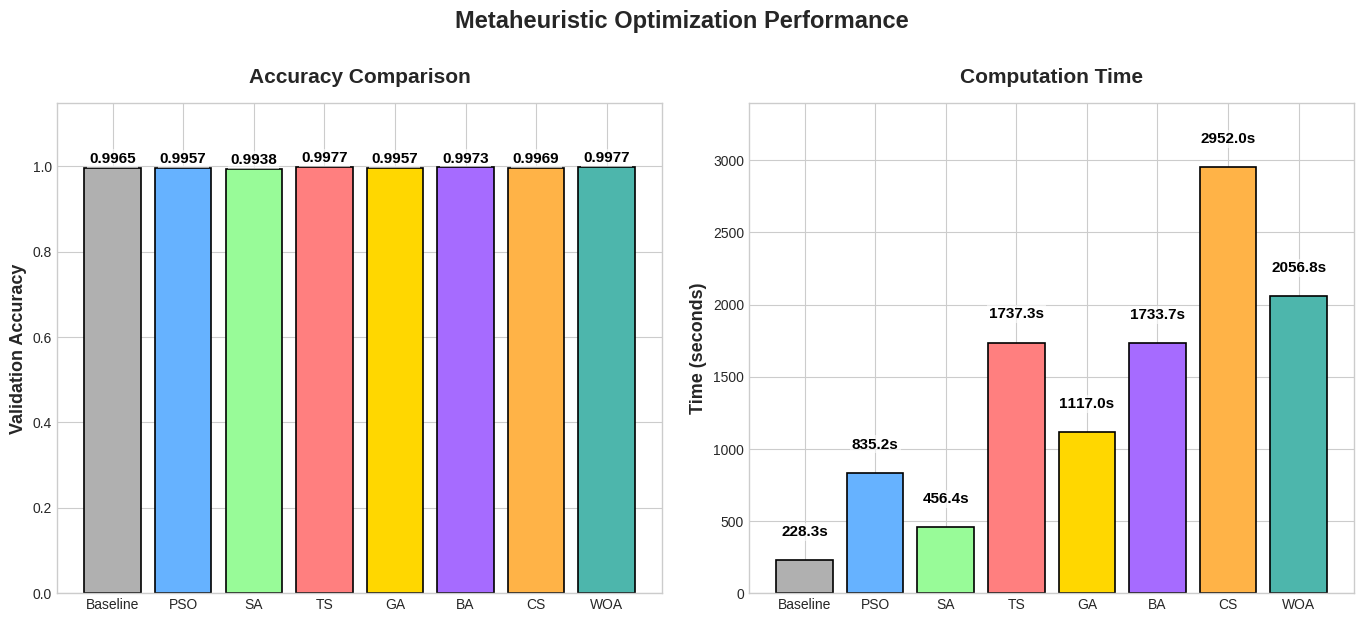

In [ ]:
algorithms = ["Baseline", "PSO", "SA", "TS", "GA", "BA", "CS", "WOA"]
accuracies = df_comparison["Accuracy"].values
times = df_comparison["Time (s)"].values

colors = ["#B0B0B0", "#66B2FF", "#98FB98", "#FF7F7F","#FFD700", "#A66BFF","#FFB347","#4DB6AC",]

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
bars = ax1.bar(algorithms, accuracies, color=colors, edgecolor="black", linewidth=1.2)
ax1.set_ylabel("Validation Accuracy", fontsize=13, fontweight="bold")
ax1.set_title("Accuracy Comparison", fontsize=15, fontweight="bold", pad=15)
ax1.set_ylim(0, max(accuracies) * 1.15)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.005,
        f"{acc:.4f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.5),
    )

ax2 = plt.subplot(1, 2, 2)
bars = ax2.bar(algorithms, times, color=colors, edgecolor="black", linewidth=1.2)
ax2.set_ylabel("Time (seconds)", fontsize=13, fontweight="bold")
ax2.set_title("Computation Time", fontsize=15, fontweight="bold", pad=15)
ax2.set_ylim(0, max(times) * 1.15)

for bar, t in zip(bars, times):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.05 * max(times),
        f"{t:.1f}s",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.5),
    )

plt.tight_layout(pad=2.0)
plt.suptitle("Metaheuristic Optimization Performance", fontsize=17, fontweight="bold", y=1.05)
plt.show()

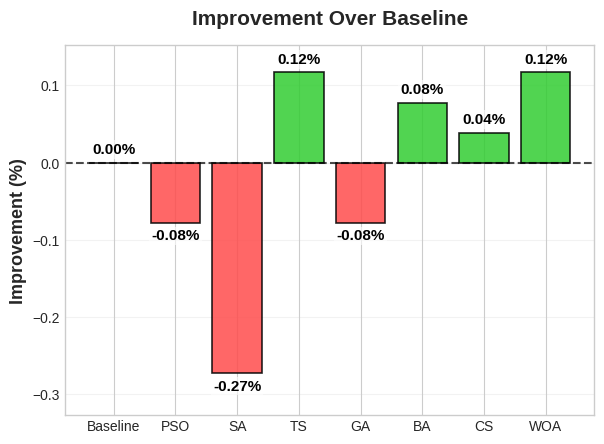

In [ ]:
# Improvement over Baseline
ax3 = plt.subplot(1, 1, 1)

improvements = df_comparison['Improvement (%)'].values
algorithms = ['Baseline', 'PSO', 'SA', 'TS', 'GA', 'BA', 'CS', 'WOA']

colors_imp = [
    '#32CD32' if x > 0 else '#FF4C4C' if x < 0 else '#B0B0B0'
    for x in improvements
]

bars = ax3.bar(
    algorithms,
    improvements,
    color=colors_imp,
    edgecolor='black',
    linewidth=1.2,
    alpha=0.85
)

# Labels
ax3.set_ylabel('Improvement (%)', fontsize=13, fontweight='bold')
ax3.set_title('Improvement Over Baseline', fontsize=15, fontweight='bold', pad=15)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_ylim(min(improvements) * 1.2, max(improvements) * 1.3)
ax3.grid(axis='y', alpha=0.25)

# Annotate bars
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    offset = 0.02 * (max(improvements) - min(improvements))
    ax3.text(
        bar.get_x() + bar.get_width()/2.,
        height + offset if imp >= 0 else height - offset,
        f'{imp:.2f}%',
        ha='center',
        va='bottom' if imp >= 0 else 'top',
        fontsize=11,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5)
    )

plt.tight_layout(pad=2)
plt.show()

## Train final model with best parameters

 Training Final Model with Best Parameters
Best algorithm: TS
Best parameters:
  Learning Rate: 0.001613
  Dropout: 0.4191
  Batch Size: 61
  Conv Layers: 5
  Base Filters: 45
Found 10305 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
 Training final model with extended epochs
Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 328ms/step - accuracy: 0.9687 - loss: 0.2097 - val_accuracy: 0.9717 - val_loss: 0.1085 - learning_rate: 0.0016
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - accuracy: 0.9897 - loss: 0.0349 - val_accuracy: 0.5947 - val_loss: 0.6673 - learning_rate: 0.0016
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.9916 - loss: 0.0212 - val_accuracy: 0.9713 - val_loss: 0.3832 - learning_rate: 0.0016
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.9952 - loss: 0.0140 - val_accuracy: 0.9961 - val_loss: 0.0123 - learning_rate: 0.0016
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.9958 - 

 Final Model Accuracy: 0.9961
 Final Model Loss: 0.0123
 Final model saved: final_model_TS_20251221_213704.h5
 Final training plot saved: final_model_training_20251221_213704.png


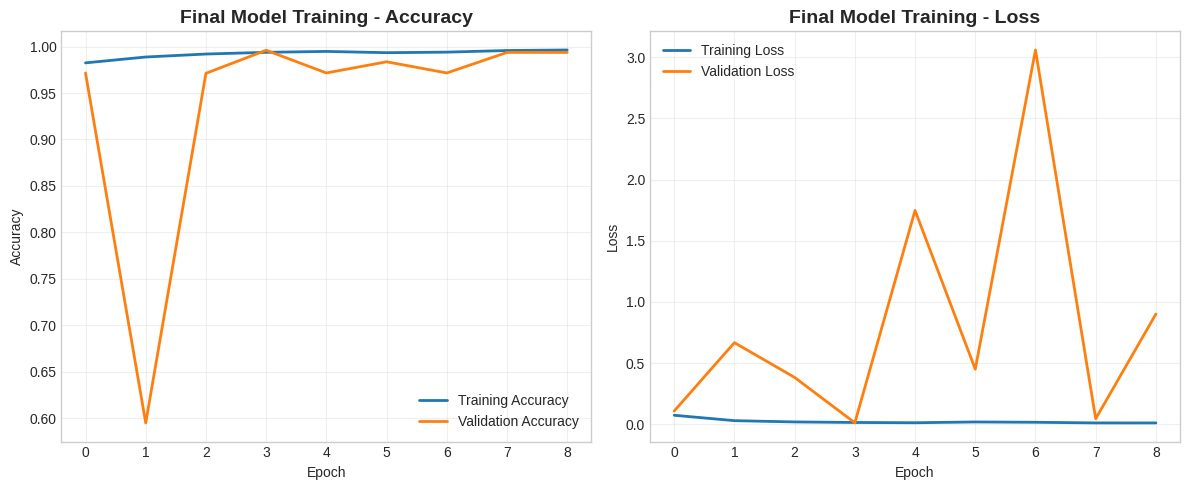

In [ ]:
print(" Training Final Model with Best Parameters")

# Select best algorithm among ALL metaheuristics
best_algo = max(results.keys(), key=lambda k: results[k]["score"])
best_params_final = results[best_algo]["params"]
best_score_final = results[best_algo]["score"]

print(f"Best algorithm: {best_algo}")
print("Best parameters:")
print(f"  Learning Rate: {best_params_final[0]:.6f}")
print(f"  Dropout: {best_params_final[1]:.4f}")
print(f"  Batch Size: {int(best_params_final[2])}")
print(f"  Conv Layers: {int(best_params_final[3])}")
print(f"  Base Filters: {int(best_params_final[4])}")

# Build final model
final_model, batch_size = build_flexible_cnn(
    best_params_final, num_classes, input_shape
)
train_gen, val_gen = create_data_generators(batch_size=batch_size)

print(" Training final model with extended epochs")
final_history = final_model.fit(
    train_gen,
    epochs=20,
    verbose=1,
    validation_data=val_gen,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
        ),
    ],
)

final_loss, final_acc = final_model.evaluate(val_gen)

print(f" Final Model Accuracy: {final_acc:.4f}")
print(f" Final Model Loss: {final_loss:.4f}")

# Save model
model_filename = f"final_model_{best_algo}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
final_model.save(model_filename)
print(f" Final model saved: {model_filename}")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(final_history.history["val_accuracy"], label="Validation Accuracy", linewidth=2)
plt.title("Final Model Training - Accuracy", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(final_history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(final_history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("Final Model Training - Loss", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
final_plot_filename = f"final_model_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plt.savefig(final_plot_filename, dpi=300, bbox_inches="tight")
print(f" Final training plot saved: {final_plot_filename}")

In [ ]:
# Final Report
print("Final Report")

print(" Dataset Information")
print(f"  Total Samples: {train_data.samples + val_data.samples}")
print(f"  Training Samples: {train_data.samples}")
print(f"  Validation Samples: {val_data.samples}")
print(f"  Number of Classes: {num_classes}")
print(f"  Input Shape: {input_shape}")

print(" Base Model")
print(f"  Accuracy: {baseline_acc:.4f}")
print(f"  Training Time: {baseline_time:.2f}s")

print(" Optimization Results")
print(f"  Best Algorithm: {best_algo}")
print(f"  Best Accuracy: {best_score_final:.4f}")
print(f"  Improvement: {(best_score_final - baseline_acc)/baseline_acc * 100:.2f}%")
print(f"  Final Model Accuracy: {final_acc:.4f}")

print(" Algoritms Comparison")
for algo in ["PSO", "SA", "TS", "GA", "BA", "CS"]:
    score = results[algo]["score"]
    time_taken = results[algo]["time"]
    improvement = (score - baseline_acc) / baseline_acc * 100
    print(f"  {algo:15} Acc: {score:.4f}  Time: {time_taken:6.1f}s  Improvement: {improvement:+6.2f}%")

plt.show()

Final Report
 Dataset Information
  Total Samples: 12881
  Training Samples: 10305
  Validation Samples: 2576
  Number of Classes: 2
  Input Shape: (128, 128, 3)
 Base Model
  Accuracy: 0.9965
  Training Time: 228.31s
 Optimization Results
  Best Algorithm: TS
  Best Accuracy: 0.9977
  Improvement: 0.12%
  Final Model Accuracy: 0.9961
 Algoritms Comparison
  PSO             Acc: 0.9957  Time:  835.2s  Improvement:  -0.08%
  SA              Acc: 0.9938  Time:  456.4s  Improvement:  -0.27%
  TS              Acc: 0.9977  Time: 1737.3s  Improvement:  +0.12%
  GA              Acc: 0.9957  Time: 1117.0s  Improvement:  -0.08%
  BA              Acc: 0.9973  Time: 1733.7s  Improvement:  +0.08%
  CS              Acc: 0.9969  Time: 2952.0s  Improvement:  +0.04%


## XAI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

# Install LIME if needed
try:
    from lime import lime_image
    from skimage.segmentation import slic, mark_boundaries
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'lime', 'scikit-image'])
    from lime import lime_image
    from skimage.segmentation import slic, mark_boundaries

In [ ]:
# METRICS
def calc_stability(explanations):
    if len(explanations) < 2: return 0.0
    corrs = []
    for i in range(len(explanations)):
        for j in range(i+1, len(explanations)):
            e1, e2 = explanations[i].flatten(), explanations[j].flatten()
            corr = np.corrcoef(e1, e2)[0,1]
            if not np.isnan(corr): corrs.append(corr)
    return np.mean(corrs) if corrs else 0.0

def calc_sparsity(explanation, threshold=0.1):
    flat = np.abs(explanation.flatten())
    if flat.max() == 0: return 1.0
    norm = flat / flat.max()
    return (norm > threshold).sum() / len(norm)

In [ ]:
# LIME WRAPPER
class OptimizableLIME:
    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names

    def explain(self, X, num_samples=300, num_features=50, kernel_width=1.0, num_runs=3):
        num_samples = int(np.clip(num_samples, 100, 1000))
        num_features = int(np.clip(num_features, 10, 100))
        kernel_width = float(np.clip(kernel_width, 0.1, 5.0))

        try:
            explainer = lime_image.LimeImageExplainer()
            explanations = []

            for _ in range(num_runs):
                exp_list = []
                for img in X:
                    explanation = explainer.explain_instance(
                        img,
                        lambda x: self.model.predict(x, verbose=0),
                        top_labels=1,
                        hide_color=0,
                        num_samples=num_samples,
                        segmentation_fn=lambda x: slic(x, n_segments=num_features, compactness=10)
                    )

                    top_label = explanation.top_labels[0]
                    mask = explanation.get_image_and_mask(
                        top_label, positive_only=True,
                        num_features=num_features, hide_rest=False
                    )[1]
                    exp_list.append(mask)

                explanations.append(np.array(exp_list))

            stability = calc_stability(explanations)
            sparsity = np.mean([calc_sparsity(exp) for exp in explanations])
            avg_explanation = np.mean(explanations, axis=0)

            return explanations, stability, sparsity, avg_explanation

        except Exception as e:
            print(f"  LIME error: {e}")
            return [], 0.0, 1.0, None

In [ ]:
# Get test samples
X_test, y_test = [], []
for i in range(min(3, len(val_data))):
    X_batch, y_batch = val_data[i]
    X_test.append(X_batch[:5])
    y_test.append(y_batch[:5])

X_test = np.vstack(X_test)[:15]
y_test = np.vstack(y_test)[:15]
print(f" Prepared {len(X_test)} test samples")

lime_explainer = OptimizableLIME(final_model, list(train_data.class_indices.keys()))

 Prepared 15 test samples


In [ ]:
# FITNESS FUNCTION
def fitness_lime(params):
    num_samples = int(np.clip(params[0], 100, 1000))
    num_features = int(np.clip(params[1], 10, 100))
    kernel_width = float(np.clip(params[2], 0.1, 5.0))

    try:
        start_time = time.time()

        explanations, stability, sparsity, _ = lime_explainer.explain(
            X_test[:5],
            num_samples=num_samples,
            num_features=num_features,
            kernel_width=kernel_width,
            num_runs=2
        )

        exec_time = time.time() - start_time

        if len(explanations) == 0:
            return 0.0

        time_penalty = min(exec_time / 15.0, 1.0)
        fitness = 0.5*stability + 0.3*(1-sparsity) + 0.2*(1-time_penalty)

        return float(fitness)

    except Exception as e:
        print(f"  Error: {e}")
        return 0.0

LIME_BOUNDS = [(100, 1000), (10, 100), (0.1, 5.0)]
LIME_DISCRETE = [True, True, False]

In [ ]:
# METAHEURISTIC CLASSES
class PSO:
    def __init__(self, n=4, iters=1, w=0.7, c1=1.5, c2=1.5):
        self.n, self.iters, self.w, self.c1, self.c2 = n, iters, w, c1, c2
    def optimize(self, f, bounds, disc):
        d, lo, hi = len(bounds), np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
        X, V = np.random.uniform(lo,hi,(self.n,d)), np.random.randn(self.n,d)*0.1
        pb, pbs = X.copy(), np.array([f(x) for x in X])
        gb, gbs = pb[np.argmax(pbs)].copy(), pbs.max()
        hist = []
        for t in range(self.iters):
            for i in range(self.n):
                V[i] = self.w*V[i]+self.c1*np.random.rand(d)*(pb[i]-X[i])+self.c2*np.random.rand(d)*(gb-X[i])
                X[i] = np.clip(X[i]+V[i],lo,hi)
                for j,dd in enumerate(disc):
                    if dd: X[i][j]=round(X[i][j])
                s = f(X[i])
                if s>pbs[i]:
                    pb[i],pbs[i]=X[i].copy(),s
                    if s>gbs: gb,gbs=X[i].copy(),s
            hist.append({'iteration':t+1,'best_score':gbs})
            print(f"  PSO Iter {t+1}: {gbs:.4f}")
        return gb,gbs,hist

class BAT:
    def __init__(self, n=4, iters=1, fmin=0, fmax=2, loud=0.9, pulse=0.5):
        self.n,self.iters,self.fmin,self.fmax,self.loud,self.pulse=n,iters,fmin,fmax,loud,pulse
    def optimize(self, f, bounds, disc):
        d, lo, hi = len(bounds), np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
        X, V, freq = np.random.uniform(lo,hi,(self.n,d)), np.zeros((self.n,d)), np.zeros(self.n)
        for i in range(self.n):
            for j,dd in enumerate(disc):
                if dd: X[i][j]=round(X[i][j])
        scores = np.array([f(x) for x in X])
        best, bs = X[scores.argmax()].copy(), scores.max()
        hist = []
        for t in range(self.iters):
            for i in range(self.n):
                freq[i]=self.fmin+(self.fmax-self.fmin)*np.random.rand()
                V[i]+=(X[i]-best)*freq[i]
                cand=np.clip(X[i]+V[i] if np.random.rand()<=self.pulse else best+0.001*np.random.randn(d)*(hi-lo),lo,hi)
                for j,dd in enumerate(disc):
                    if dd: cand[j]=round(cand[j])
                s=f(cand)
                if s>scores[i] and np.random.rand()<self.loud:
                    X[i],scores[i]=cand.copy(),s
                    if s>bs: best,bs=cand.copy(),s
            hist.append({'iteration':t+1,'best_score':bs})
            print(f"  BAT Iter {t+1}: {bs:.4f}")
        return best,bs,hist

class CS:
    def __init__(self, n=6, iters=1, pa=0.25, step=0.1):
        self.n, self.iters, self.pa, self.step = n, iters, pa, step
    def optimize(self, f, bounds, disc):
        d, lo, hi = len(bounds), np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
        X = np.random.uniform(lo,hi,(self.n,d))
        for i in range(self.n):
            for j,dd in enumerate(disc):
                if dd: X[i][j]=round(X[i][j])
        fit = np.array([f(x) for x in X])
        best, bs = X[fit.argmax()].copy(), fit.max()
        hist = []
        for t in range(self.iters):
            for i in range(self.n):
                cand = np.clip(X[i]+self.step*np.random.randn(d)*(hi-lo),lo,hi)
                for j,dd in enumerate(disc):
                    if dd: cand[j]=round(cand[j])
                s, j = f(cand), np.random.randint(0,self.n)
                if s>fit[j]:
                    X[j],fit[j]=cand.copy(),s
                    if s>bs: best,bs=cand.copy(),s
            for i in range(self.n):
                if np.random.rand()<self.pa:
                    X[i]=np.random.uniform(lo,hi,d)
                    for j,dd in enumerate(disc):
                        if dd: X[i][j]=round(X[i][j])
                    fit[i]=f(X[i])
                    if fit[i]>bs: best,bs=X[i].copy(),fit[i]
            hist.append({'iteration':t+1,'best_score':bs})
            print(f"  CS Iter {t+1}: {bs:.4f}")
        return best,bs,hist

class GA:
    def __init__(self, pop=5, gens=1, mut=0.15, cross=0.8):
        self.pop, self.gens, self.mut, self.cross = pop, gens, mut, cross
    def optimize(self, f, bounds, disc):
        d, lo, hi = len(bounds), np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
        population = [np.random.uniform(lo,hi,d) for _ in range(self.pop)]
        for p in population:
            for i,dd in enumerate(disc):
                if dd: p[i]=round(p[i])
        best, bs, hist = None, -np.inf, []
        for g in range(self.gens):
            fit = np.array([f(ind) for ind in population])
            if fit.max()>bs: bs,best=fit.max(),population[fit.argmax()].copy()
            hist.append({'generation':g+1,'best_score':bs})
            print(f"  GA Gen {g+1}: {bs:.4f}")
            new_pop = [best.copy()]
            while len(new_pop)<self.pop:
                i1,i2=np.random.choice(len(population),2,replace=False)
                p1=population[i1] if fit[i1]>fit[i2] else population[i2]
                i1,i2=np.random.choice(len(population),2,replace=False)
                p2=population[i1] if fit[i1]>fit[i2] else population[i2]
                child = np.concatenate([p1[:d//2],p2[d//2:]]) if np.random.rand()<self.cross else p1.copy()
                for i in range(d):
                    if np.random.rand()<self.mut:
                        child[i]=(np.random.randint(bounds[i][0],bounds[i][1]+1) if disc[i] else
                                 np.clip(child[i]+np.random.randn()*0.1*(hi[i]-lo[i]),lo[i],hi[i]))
                new_pop.append(child)
            population = new_pop[:self.pop]
        return best,bs,hist

In [ ]:
# Reuse metaheuristic classes (PSO, BAT, GA, CS)
xai_results = {}

# PSO for LIME
print(" PSO-LIME")
t0 = time.time()
pso_lime = PSO(n=4, iters=1, w=0.7, c1=1.5, c2=1.5)
p, s, h = pso_lime.optimize(fitness_lime, LIME_BOUNDS, LIME_DISCRETE)
xai_results['PSO'] = {'params': p, 'score': s, 'time': time.time()-t0, 'history': h}
print(f" PSO-LIME: {s:.4f} ({xai_results['PSO']['time']:.1f}s)")
print(f"  num_samples={int(p[0])}, num_features={int(p[1])}, kernel_width={p[2]:.2f}")

# GA for LIME
print(" GA-LIME")
t0 = time.time()
ga_lime = GA(pop=5, gens=1)
p, s, h = ga_lime.optimize(fitness_lime, LIME_BOUNDS, LIME_DISCRETE)
xai_results['GA'] = {'params': p, 'score': s, 'time': time.time()-t0, 'history': h}
print(f" GA-LIME: {s:.4f} ({xai_results['GA']['time']:.1f}s)")
print(f"  num_samples={int(p[0])}, num_features={int(p[1])}, kernel_width={p[2]:.2f}")

# BAT for LIME
print(" BAT-LIME")
t0 = time.time()
ba_lime = BAT(n=4, iters=1)
p, s, h = ba_lime.optimize(fitness_lime, LIME_BOUNDS, LIME_DISCRETE)
xai_results['BAT'] = {'params': p, 'score': s, 'time': time.time()-t0, 'history': h}
print(f" BAT-LIME: {s:.4f} ({xai_results['BAT']['time']:.1f}s)")
print(f"  num_samples={int(p[0])}, num_features={int(p[1])}, kernel_width={p[2]:.2f}")

# Cuckoo for LIME
print(" Cuckoo-LIME")
t0 = time.time()
cs_lime = CS(n=6, iters=1)
p, s, h = cs_lime.optimize(fitness_lime, LIME_BOUNDS, LIME_DISCRETE)
xai_results['Cuckoo'] = {'params': p, 'score': s, 'time': time.time()-t0, 'history': h}
print(f" Cuckoo-LIME: {s:.4f} ({xai_results['Cuckoo']['time']:.1f}s)")
print(f"  num_samples={int(p[0])}, num_features={int(p[1])}, kernel_width={p[2]:.2f}")

 PSO-LIME


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  PSO Iter 1: 0.5634
 PSO-LIME: 0.5634 (368.1s)
  num_samples=378, num_features=60, kernel_width=3.01
 GA-LIME


  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/266 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  GA Gen 1: 0.5661
 GA-LIME: 0.5661 (227.0s)
  num_samples=873, num_features=33, kernel_width=0.56
 BAT-LIME


  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/868 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/889 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  0%|          | 0/857 [00:00<?, ?it/s]

  BAT Iter 1: 0.5981
 BAT-LIME: 0.5981 (570.4s)
  num_samples=889, num_features=11, kernel_width=2.37
 Cuckoo-LIME


  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  CS Iter 1: 0.6655
 Cuckoo-LIME: 0.6655 (481.1s)
  num_samples=100, num_features=24, kernel_width=3.30


LIME PARAMETER OPTIMIZATION RESULTS
Method  Fitness Score   Time (s)
   PSO       0.563435 368.142295
    GA       0.566130 227.036620
   BAT       0.598082 570.425686
Cuckoo       0.665548 481.107846


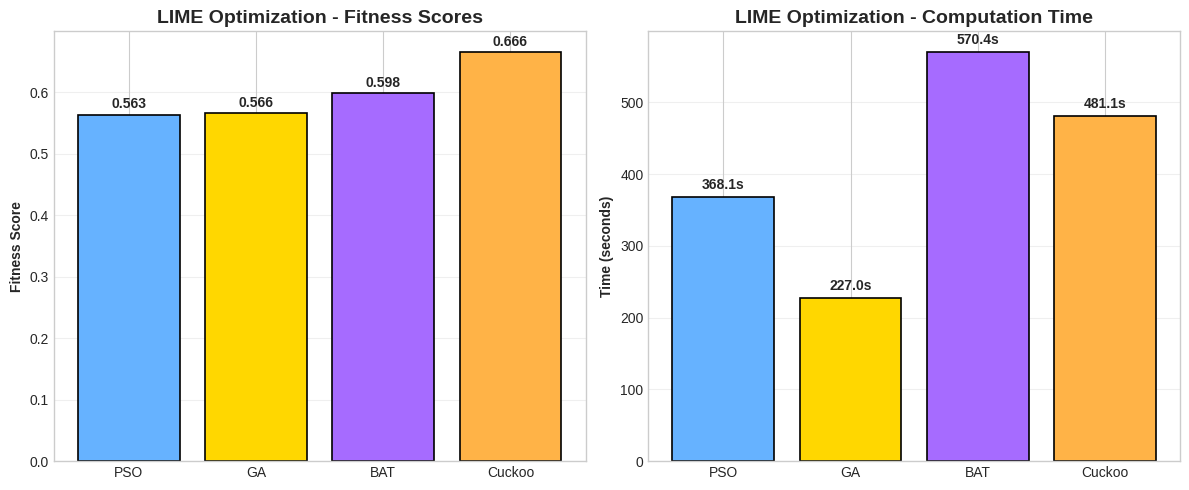

In [ ]:
# VISUALIZATION
methods = list(xai_results.keys())
scores = [xai_results[k]['score'] for k in methods]
times = [xai_results[k]['time'] for k in methods]

import pandas as pd
df_xai = pd.DataFrame({
    'Method': methods,
    'Fitness Score': scores,
    'Time (s)': times
})

print("LIME PARAMETER OPTIMIZATION RESULTS")
print(df_xai.to_string(index=False))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#66B2FF', '#FFD700', '#A66BFF', '#FFB347']

bars1 = ax1.bar(methods, scores, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Fitness Score', fontweight='bold')
ax1.set_title('LIME Optimization - Fitness Scores', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars1, scores):
    ax1.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
            f'{score:.3f}', ha='center', fontsize=10, fontweight='bold')

bars2 = ax2.bar(methods, times, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Time (seconds)', fontweight='bold')
ax2.set_title('LIME Optimization - Computation Time', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, t in zip(bars2, times):
    ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+max(times)*0.02,
            f'{t:.1f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'lime_optimization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png',
           dpi=300, bbox_inches='tight')
plt.show()

Generating Sample Explanations with Best Parameters
 Best method: Cuckoo
 num_samples=100, num_features=24, kernel_width=3.30


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

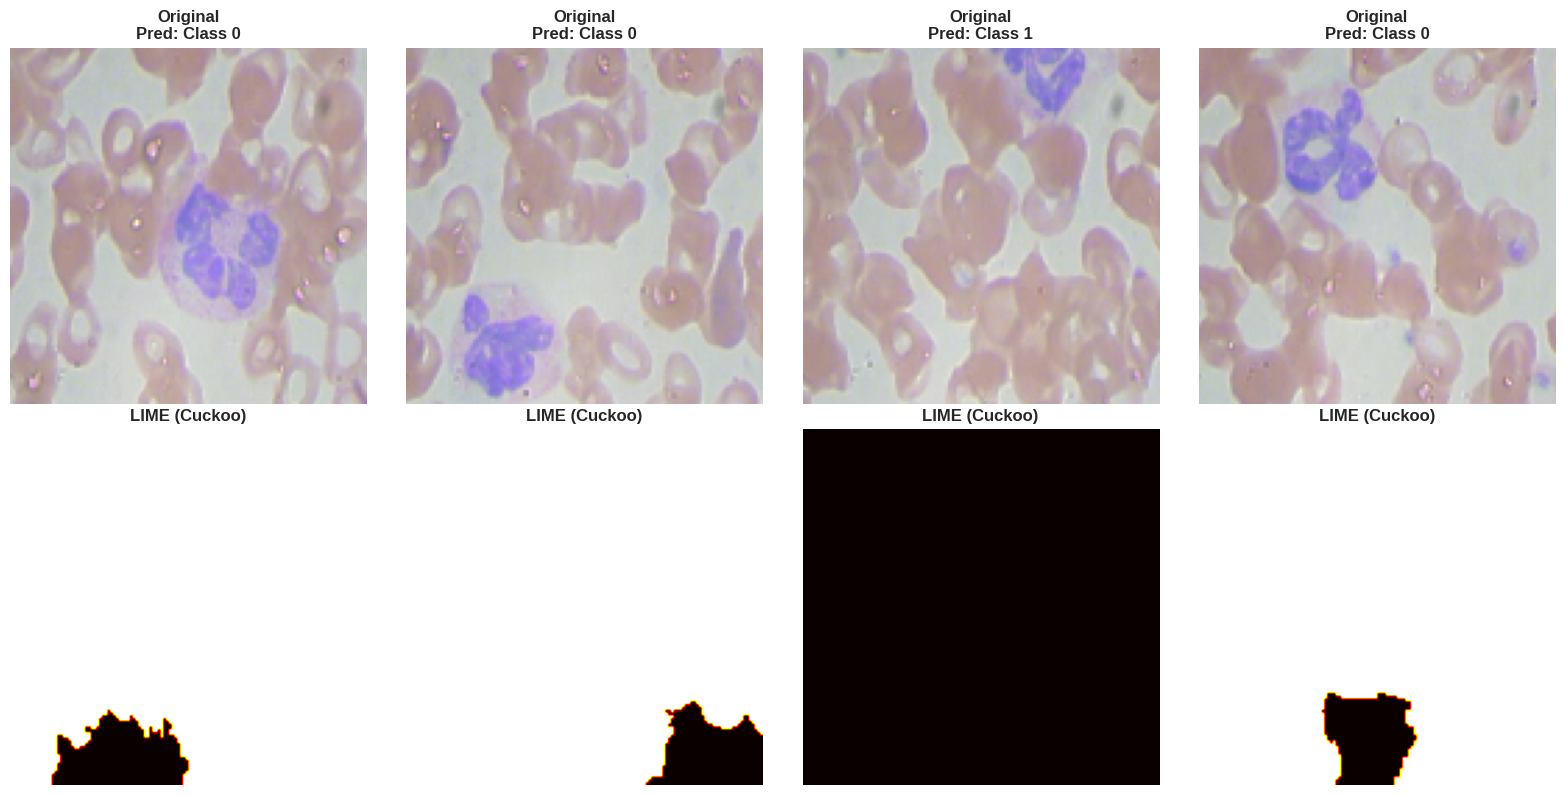

Best Method: Cuckoo
Best Fitness: 0.6655
Stability: N/A
Sparsity: 0.7105


In [ ]:
# GENERATE SAMPLE EXPLANATIONS
print("Generating Sample Explanations with Best Parameters")
best_method = max(methods, key=lambda k: xai_results[k]['score'])
best_params = xai_results[best_method]['params']

print(f" Best method: {best_method}")
print(f" num_samples={int(best_params[0])}, num_features={int(best_params[1])}, kernel_width={best_params[2]:.2f}")

sample_images = X_test[:4]
explanations, stability, sparsity, _ = lime_explainer.explain(
    sample_images,
    num_samples=int(best_params[0]),
    num_features=int(best_params[1]),
    kernel_width=best_params[2],
    num_runs=1
)

# Visualize
fig = plt.figure(figsize=(16, 8))
for i in range(4):
    # Original
    ax = plt.subplot(2, 4, i+1)
    ax.imshow(sample_images[i])
    pred = np.argmax(final_model.predict(sample_images[i:i+1], verbose=0))
    ax.set_title(f'Original\nPred: Class {pred}', fontweight='bold')
    ax.axis('off')

    # LIME Explanation
    if len(explanations) > 0:
        ax = plt.subplot(2, 4, i+5)
        ax.imshow(explanations[0][i], cmap='hot', interpolation='bilinear')
        ax.set_title(f'LIME ({best_method})', fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.savefig(f'lime_explanations_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png',
           dpi=300, bbox_inches='tight')
plt.show()
print(f"Best Method: {best_method}")
print(f"Best Fitness: {xai_results[best_method]['score']:.4f}")
print(f"Stability: {stability:.4f}" if stability else "Stability: N/A")
print(f"Sparsity: {sparsity:.4f}" if sparsity else "Sparsity: N/A")